In [83]:
import os
import pandas as pd

dataset_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app','static','uploads', 'dataset.csv'))
df_comments = pd.read_csv(dataset_path)
df_comments.tail(n=99)

,comment,label
0,Aku mampir kesini karena mau coba beli alhamdu...,positif
1,Udah pake sleeping mask yang yuja ini dari per...,positif
2,Sleeping masknya juaraaaaa habisnya lama banget,positif
3,kalo pake moisturizer kog poriku jadi keliatan...,negatif
4,Aku lg pake yg luminous beneran bikin glowing ...,negatif
5,wah ternyata bukan aku aja yang gak cocok sama...,negatif


In [84]:
# Melihat jumlah data
df_comments['label'].value_counts()

label
positif    3
negatif    3
Name: count, dtype: int64

#### Preprocessing

In [85]:
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
combined_stopwords = set(stopword_factory.get_stop_words()).union(set(stopwords.words('english')))

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in combined_stopwords]
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)


df_comments['preprocess'] = df_comments['comment'].apply(preprocess_text)
df_comments

,comment,label,preprocess
0,Aku mampir kesini karena mau coba beli alhamdu...,positif,aku mampir kesini mau coba beli alhamdulillah ...
1,Udah pake sleeping mask yang yuja ini dari per...,positif,udah pake sleeping mask yuja pertama rilis ema...
2,Sleeping masknya juaraaaaa habisnya lama banget,positif,sleeping masknya juaraaaaa habis lama banget
3,kalo pake moisturizer kog poriku jadi keliatan...,negatif,kalo pake moisturizer kog pori jadi liat besar...
4,Aku lg pake yg luminous beneran bikin glowing ...,negatif,aku lg pake yg luminous beneran bikin glowing ...
5,wah ternyata bukan aku aja yang gak cocok sama...,negatif,wah nyata bukan aku aja gak cocok sama skintif...


#### Visual Polarisasi Kata

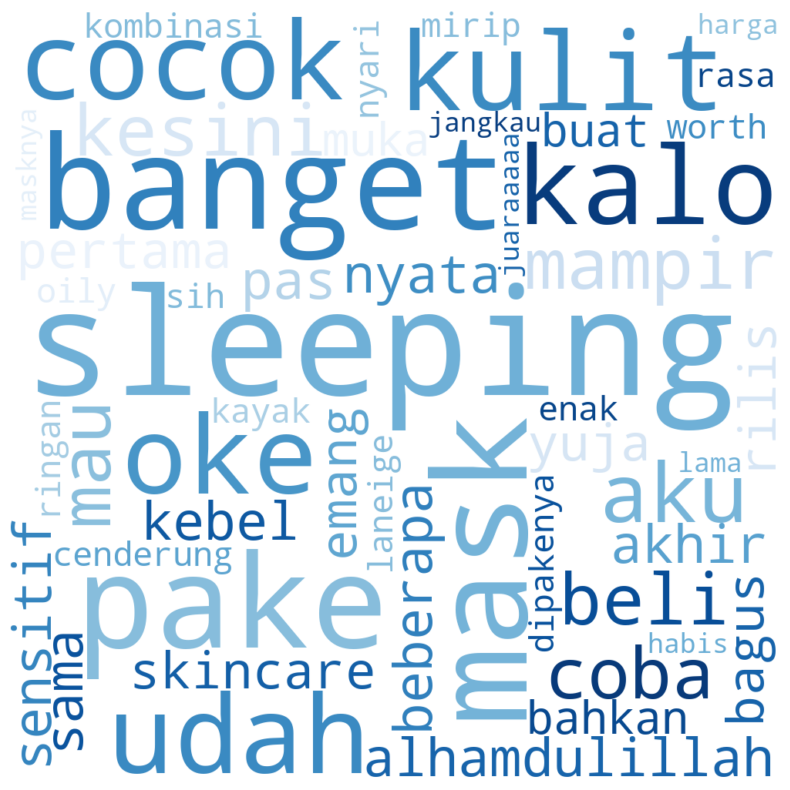

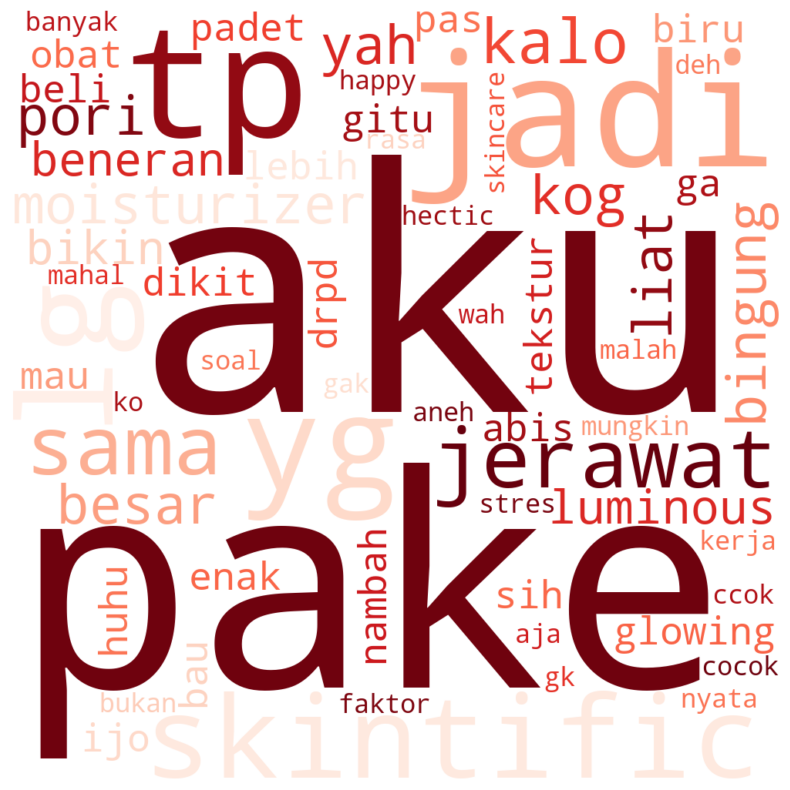

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# polarisasi positif
dataset_negatif = df_comments[df_comments['label'] == 'positif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# polarisasi negatif
dataset_negatif = df_comments[df_comments['label'] == 'negatif']
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

#### Bagi dataset menjadi 80% data training dan 20% data testing

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_comments['preprocess'], df_comments['label'], test_size=0.2, stratify=df_comments['label'], random_state=0)

In [88]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_comments['preprocess'])

terms = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

# Create DataFrame for TF-IDF
tfidf_df = pd.DataFrame(X.toarray().T, index=terms, columns=[f'D{i+1}' for i in range(len(df_comments['preprocess']))])
idf_df = pd.DataFrame(idf_values, index=terms, columns=["IDF"])

# Function to compute raw TF (counts of terms in document)
def compute_raw_tf(doc):
    words = doc.split()
    count = Counter(words)
    return count

# Compute raw TF for each document (term count)
raw_tf_dicts = [compute_raw_tf(doc) for doc in df_comments['preprocess']]
raw_tf_df = pd.DataFrame(raw_tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

# Compute normalized TF
def compute_tf(doc):
    words = doc.split()
    count = Counter(words)
    total_terms = len(words)
    tf = {term: count[term] / total_terms for term in count}
    return tf

# Compute normalized TF for each document
tf_dicts = [compute_tf(doc) for doc in df_comments['preprocess']]
tf_df = pd.DataFrame(tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

# Fill NaN values with 0
raw_tf_df = raw_tf_df.fillna(0)
tf_df = tf_df.fillna(0)
idf_df = idf_df.fillna(0)
tfidf_df = tfidf_df.fillna(0)

# Sum all normalized TF values across all documents (TFNormAll)
tf_norm_all = tf_df.sum(axis=1)

# Compute Document Frequency (DF) - number of documents where the term appears
df_values = (raw_tf_df > 0).sum(axis=1)

# Create final DataFrame
final_df = pd.DataFrame(index=terms)
final_df['Terms'] = terms

# Add raw TF for each document (Raw Terms per document)
final_df = final_df.join(raw_tf_df.add_prefix('TF'))  # Add raw term counts for each document

# Add normalized TF for each document
final_df = final_df.join(tf_df.add_prefix('TFN'))  # Add normalized TF for each document

# Add sum of normalized TFs across all documents
final_df['TFNAll'] = tf_norm_all

# Add Document Frequency (DF) column
final_df['DF'] = df_values

# Add IDF column
final_df['IDF'] = idf_df['IDF']

# Add TF-IDF for each document
final_df = final_df.join(tfidf_df.add_prefix('TFIDF_'))

# Round all numeric columns to 3 decimal places
final_df = final_df.round(3)

# Export the final DataFrame to CSV
final_df.to_csv('combined_tfidf_output.csv', index=False)

print("Exported 'combined_tfidf_output.csv' with values rounded to 3 decimal places.")


Exported 'combined_tfidf_output.csv' with values rounded to 3 decimal places.


In [89]:
# run once
# Vektor Hasil tranformasi term data testing dengan data training
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# print(X_train.toarray())
# print(X_test.toarray())

#### Prediksi Kelas Dataset

In [90]:
# Tampilkan hasil prediksi data test
from sklearn.svm import SVC

model = SVC(random_state=0, kernel='linear')

model.fit(X_train, y_train)
predict = model.predict(X_test)
print(predict)


['negatif' 'positif']


#### Hitung Akurasi

In [91]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# f1-score
print('F1-Score : ', f1_score(y_test, predict, pos_label='positif'))
# Accuracy
print('Accuracy : ', accuracy_score(y_test, predict))
# precision
print('Precision : ', precision_score(y_test, predict, pos_label='positif'))
# recall
print('Recall : ', recall_score(y_test, predict, pos_label='positif'))


# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
tn, fp, fn, tp


F1-Score :  1.0
Accuracy :  1.0
Precision :  1.0
Recall :  1.0


(np.int64(1), np.int64(0), np.int64(0), np.int64(1))